## Importing dependencies

### First Party

Importing custom classes from the codebase:
- **dataset**: helper _torch_ wrapper around _facades_ dataset.
- **pix2pix**: implementation of _Pix2Pix_ architecture. Both generator and discriminator and the corresponding loss functions.

### Third Party

- **os**: to create directories, save weights.
- **opencv**: image processing library, helps to load/save images.
- **numpy**: nd arrays utilities, includes math and arithmetics.
- **torch**: ML framework, extremelly friendly to GPU, the network architecture was specifically designed in torch.
- **torchvision**: set of image transformations, like crop and flip. It is important to use _v2_ transforms as it can apply the same transformations to image and corresponding segmentation labels where stochastic operations used. 
- **matplotlib**: library to visualise data.
- **tqdm**: visualises progress.

In [11]:
# 3rd Party dependencies.
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms.v2 as transforms

from torch.utils.data import DataLoader
from tqdm import tqdm

# 1st Party dependencies.
from dataset.facades_dataset import FacadesDataset
from cyclegan.generator import Generator
from cyclegan.discriminator import Discriminator

%matplotlib inline

## Pre-processing data

I decided to use the same pre-processing as was used for _Pix2Pix_ training. The pre-processing does not create too much disturbance in the data, so the model can learn something from it and at the same time it enriches the train dataset.

In [2]:
# Applying the same transformations as were applied to Pix2Pix train dataset.
train_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    # Resizing the 256×256 input images to 286×286.
    transforms.Resize((286, 286)), 
    # Randomly cropping back to size 256×256.
    transforms.RandomCrop(256),
    # Mirroring.
    transforms.RandomHorizontalFlip(),
])

default_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])

In [3]:
facades_train_dataset = FacadesDataset(root_dir='dataset/facades', split='train', transformations=train_transforms)
facades_val_dataset = FacadesDataset(root_dir='dataset/facades', split='val', transformations=default_transforms)

train_dataloader = DataLoader(facades_train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_dataloader = DataLoader(facades_val_dataset, batch_size=1, shuffle=True)

## Training cycle

- **learning rate**: 0.0003
- **lambda for cycle loss**: 10, quite big to pay a lot of attention to _x -> G(x) -> F(G(x))_ cycle.
- **epochs**: 100, seems enough to train 

In [4]:
def train_one_epoch(
    data_loader,
    generator_x,
    discriminator_x,
    generator_y,
    discriminator_y,
    optimiser_generator,
    optimiser_discriminator,
    l1_loss_func, 
    mse_loss_func,
    lambda_factor,
    device):
    d_losses = []
    g_losses = []
    
    for y, x in tqdm(data_loader):
        y = y.to(device)
        x = x.to(device)

        fake_x = generator_x(y)
        d_x_real = discriminator_x(x)
        d_x_fake = discriminator_x(fake_x.detach())
        d_x_real_loss = mse_loss_func(d_x_real, torch.ones_like(d_x_real))
        d_x_fake_loss = mse_loss_func(d_x_fake, torch.zeros_like(d_x_fake))
        d_x_loss = d_x_real_loss + d_x_fake_loss

        fake_y = generator_y(x)
        d_y_real = discriminator_y(y)
        d_y_fake = discriminator_y(fake_y.detach())
        d_y_real_loss = mse_loss_func(d_y_real, torch.ones_like(d_y_real))
        d_y_fake_loss = mse_loss_func(d_y_fake, torch.zeros_like(d_y_fake))
        d_y_loss = d_y_real_loss + d_y_fake_loss

        d_loss = (d_x_loss + d_y_loss) / 2

        optimiser_discriminator.zero_grad()
        d_loss.backward()
        optimiser_discriminator.step()

        # Adversarial losses.
        d_x_fake = discriminator_x(fake_x)
        d_y_fake = discriminator_y(fake_y)
        loss_g_x = mse_loss_func(d_x_fake, torch.ones_like(d_x_fake))
        loss_g_y = mse_loss_func(d_y_fake, torch.ones_like(d_y_fake))

        # Cycle losses.
        cycle_y = generator_y(fake_x)
        cycle_x = generator_x(fake_y)
        cycle_y_loss = l1_loss_func(y, cycle_y)
        cycle_x_loss = l1_loss_func(x, cycle_x)

        # Total generators loss.
        g_loss = loss_g_y \
            + loss_g_x \
            + cycle_y_loss * lambda_factor \
            + cycle_x_loss * lambda_factor

        optimiser_generator.zero_grad()
        g_loss.backward()
        optimiser_generator.step()

        d_losses.append(d_loss.detach().cpu().item())
        g_losses.append(g_loss.detach().cpu().item())

    return np.mean(g_losses), np.mean(d_losses)

In [5]:
# Setup.
device = ('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 3 * 1e-4
lambda_cycle = 10
epochs = 100

print('Starting training:', device, 'was selected for training')

# X domain -> Segmentation of building facades.
# Y domain -> Photorealistic building facades photos.
generator_x = Generator(img_channels=3, num_residuals=9).to(device)
discriminator_x = Discriminator(in_channels=3).to(device)
generator_y = Generator(img_channels=3, num_residuals=9).to(device)
discriminator_y = Discriminator(in_channels=3).to(device)

optimiser_generator = torch.optim.Adam(
    list(generator_x.parameters()) + list(generator_y.parameters()),
    lr=learning_rate,
    betas=(0.5, 0.999),
)

optimiser_discriminator = torch.optim.Adam(
    list(discriminator_x.parameters()) + list(discriminator_y.parameters()),
    lr=learning_rate,
    betas=(0.5, 0.999),
)

l1_loss_function = nn.L1Loss()
mse_loss_function = nn.MSELoss()

generators_history = []
discriminators_history = []

for epoch in range(epochs):
    g_loss, d_loss = train_one_epoch(
        train_dataloader,
        generator_x,
        discriminator_x,
        generator_y,
        discriminator_y,
        optimiser_generator,
        optimiser_discriminator,
        l1_loss_function, 
        mse_loss_function,
        lambda_cycle,
        device)

    generators_history.append(g_loss)
    discriminators_history.append(d_loss)

    print('Epoch:', epoch, 'generators loss:', g_loss, 'discriminators loss:', d_loss)

    weights_dir = os.path.join('out', 'weights', 'cyclegan')
    os.makedirs(weights_dir, exist_ok=True)

    torch.save(generator_x.state_dict(), os.path.join(weights_dir, f"generator-x-{epoch:03d}-{g_loss:.3f}.pt"))
    torch.save(discriminator_x.state_dict(), os.path.join(weights_dir, f"discriminator-x-{epoch:03d}-{d_loss:.3f}.pt"))
    torch.save(generator_y.state_dict(), os.path.join(weights_dir, f"generator-y-{epoch:03d}-{g_loss:.3f}.pt"))
    torch.save(discriminator_y.state_dict(), os.path.join(weights_dir, f"discriminator-y-{epoch:03d}-{d_loss:.3f}.pt"))

Starting training: cuda was selected for training


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [03:04<00:00,  2.16it/s]


Epoch: 0 generators loss: 3.6984520864486696 discriminators loss: 0.4172119065374136


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.31it/s]


Epoch: 1 generators loss: 3.395479485988617 discriminators loss: 0.34031206369400024


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.31it/s]


Epoch: 2 generators loss: 3.3803409999608993 discriminators loss: 0.27782552340999245


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:39<00:00,  4.00it/s]


Epoch: 3 generators loss: 3.381135109066963 discriminators loss: 0.26029359973967076


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:44<00:00,  3.84it/s]


Epoch: 4 generators loss: 3.2058110427856445 discriminators loss: 0.2770656220149249


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:36<00:00,  4.13it/s]


Epoch: 5 generators loss: 3.1478779870271683 discriminators loss: 0.276516601536423


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:38<00:00,  4.05it/s]


Epoch: 6 generators loss: 3.0926163423061372 discriminators loss: 0.2645002628862858


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:47<00:00,  3.71it/s]


Epoch: 7 generators loss: 3.1469064861536027 discriminators loss: 0.24020570788532494


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:46<00:00,  3.76it/s]


Epoch: 8 generators loss: 3.1263290393352507 discriminators loss: 0.25289738503284753


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:48<00:00,  3.69it/s]


Epoch: 9 generators loss: 3.1236221987009047 discriminators loss: 0.23475811197422444


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.37it/s]


Epoch: 10 generators loss: 3.1322027027606962 discriminators loss: 0.23747655643150212


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.57it/s]


Epoch: 11 generators loss: 3.1027220463752747 discriminators loss: 0.22399192553944886


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.38it/s]


Epoch: 12 generators loss: 3.0587054896354675 discriminators loss: 0.24079037870280445


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.45it/s]


Epoch: 13 generators loss: 3.1172920835018156 discriminators loss: 0.2092559993825853


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:35<00:00,  4.20it/s]


Epoch: 14 generators loss: 3.016430136561394 discriminators loss: 0.2200031483080238


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.29it/s]


Epoch: 15 generators loss: 3.012033844590187 discriminators loss: 0.22528862895909696


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.33it/s]


Epoch: 16 generators loss: 3.0162147635221483 discriminators loss: 0.21242831042036414


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.50it/s]


Epoch: 17 generators loss: 3.1577043533325195 discriminators loss: 0.1975120142009109


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.34it/s]


Epoch: 18 generators loss: 3.0684364998340605 discriminators loss: 0.1937223378755152


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.35it/s]


Epoch: 19 generators loss: 3.049899269938469 discriminators loss: 0.20333551306277514


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.37it/s]


Epoch: 20 generators loss: 2.9725892043113706 discriminators loss: 0.21077464293222875


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.55it/s]


Epoch: 21 generators loss: 2.977529923915863 discriminators loss: 0.21119324364699424


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:41<00:00,  3.92it/s]


Epoch: 22 generators loss: 2.9852751344442368 discriminators loss: 0.20000532569829374


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [02:14<00:00,  2.96it/s]


Epoch: 23 generators loss: 2.9831971627473832 discriminators loss: 0.20700930924620478


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:37<00:00,  4.09it/s]


Epoch: 24 generators loss: 2.986620982885361 discriminators loss: 0.198944417797029


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.48it/s]


Epoch: 25 generators loss: 2.973342318534851 discriminators loss: 0.2040622058394365


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:48<00:00,  3.69it/s]


Epoch: 26 generators loss: 2.9358954948186873 discriminators loss: 0.22166097398847343


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [02:13<00:00,  3.00it/s]


Epoch: 27 generators loss: 2.918706724643707 discriminators loss: 0.2034671724261716


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [02:36<00:00,  2.56it/s]


Epoch: 28 generators loss: 2.94205764234066 discriminators loss: 0.1990207351045683


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [02:09<00:00,  3.09it/s]


Epoch: 29 generators loss: 2.9641134291887283 discriminators loss: 0.2046543377591297


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:55<00:00,  3.47it/s]


Epoch: 30 generators loss: 2.919767038822174 discriminators loss: 0.17211029342142864


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:35<00:00,  4.19it/s]


Epoch: 31 generators loss: 2.9190481686592102 discriminators loss: 0.20066016325727104


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:36<00:00,  4.14it/s]


Epoch: 32 generators loss: 2.8906913471221922 discriminators loss: 0.19472158662974834


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.36it/s]


Epoch: 33 generators loss: 2.9092444771528245 discriminators loss: 0.18490686260163783


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.26it/s]


Epoch: 34 generators loss: 2.8925290912389756 discriminators loss: 0.19739935745485127


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:37<00:00,  4.09it/s]


Epoch: 35 generators loss: 2.907380060553551 discriminators loss: 0.17630352167412638


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:30<00:00,  4.41it/s]


Epoch: 36 generators loss: 2.893961240053177 discriminators loss: 0.17923316058004274


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:36<00:00,  4.15it/s]


Epoch: 37 generators loss: 2.9015851640701293 discriminators loss: 0.17740919302683322


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:37<00:00,  4.09it/s]


Epoch: 38 generators loss: 2.8546053141355516 discriminators loss: 0.2269797662133351


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:42<00:00,  3.89it/s]


Epoch: 39 generators loss: 2.8732806181907655 discriminators loss: 0.18439800711348653


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:46<00:00,  3.77it/s]


Epoch: 40 generators loss: 2.8725573444366455 discriminators loss: 0.18410714463330805


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:36<00:00,  4.14it/s]


Epoch: 41 generators loss: 2.867584544420242 discriminators loss: 0.1921935484674759


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:47<00:00,  3.74it/s]


Epoch: 42 generators loss: 2.9088428664207457 discriminators loss: 0.17485835077241063


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:39<00:00,  4.03it/s]


Epoch: 43 generators loss: 2.8775367802381515 discriminators loss: 0.1773874148365576


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [02:01<00:00,  3.28it/s]


Epoch: 44 generators loss: 2.883177174925804 discriminators loss: 0.16642395292175935


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:30<00:00,  4.42it/s]


Epoch: 45 generators loss: 2.908208649754524 discriminators loss: 0.16528517010156066


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.46it/s]


Epoch: 46 generators loss: 2.8867805755138396 discriminators loss: 0.18459592594299465


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.32it/s]


Epoch: 47 generators loss: 2.878283334970474 discriminators loss: 0.18853757039410993


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:59<00:00,  3.35it/s]


Epoch: 48 generators loss: 2.851385937333107 discriminators loss: 0.17406817387673074


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:41<00:00,  3.94it/s]


Epoch: 49 generators loss: 2.878896390795708 discriminators loss: 0.17469506826717407


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:40<00:00,  3.97it/s]


Epoch: 50 generators loss: 2.8528730458021165 discriminators loss: 0.16480132683180274


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.30it/s]


Epoch: 51 generators loss: 2.826342372894287 discriminators loss: 0.17588655187864788


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:49<00:00,  3.66it/s]


Epoch: 52 generators loss: 2.8966542106866835 discriminators loss: 0.1542855519001023


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:56<00:00,  3.45it/s]


Epoch: 53 generators loss: 2.8412584441900255 discriminators loss: 0.19350809676223435


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:39<00:00,  4.03it/s]


Epoch: 54 generators loss: 2.8369659674167633 discriminators loss: 0.16149118307046592


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:42<00:00,  3.90it/s]


Epoch: 55 generators loss: 2.796740937829018 discriminators loss: 0.19948855095775797


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:40<00:00,  3.97it/s]


Epoch: 56 generators loss: 2.8418657833337786 discriminators loss: 0.16967153866426088


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:41<00:00,  3.96it/s]


Epoch: 57 generators loss: 2.8579583734273912 discriminators loss: 0.14946467760950327


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:44<00:00,  3.82it/s]


Epoch: 58 generators loss: 2.841397071480751 discriminators loss: 0.1464697933577554


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:36<00:00,  4.13it/s]


Epoch: 59 generators loss: 2.7880623346567153 discriminators loss: 0.1829265864007175


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:41<00:00,  3.94it/s]


Epoch: 60 generators loss: 2.793555627465248 discriminators loss: 0.1564991583302617


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:43<00:00,  3.85it/s]


Epoch: 61 generators loss: 2.8329471445083616 discriminators loss: 0.14736127067822963


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:35<00:00,  4.20it/s]


Epoch: 62 generators loss: 2.8102451121807097 discriminators loss: 0.15937216121063102


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:37<00:00,  4.09it/s]


Epoch: 63 generators loss: 2.7952223229408264 discriminators loss: 0.14951378626516088


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:41<00:00,  3.93it/s]


Epoch: 64 generators loss: 2.8208092606067656 discriminators loss: 0.16149293910246343


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:46<00:00,  3.74it/s]


Epoch: 65 generators loss: 2.817641919851303 discriminators loss: 0.14570484771393238


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:44<00:00,  3.83it/s]


Epoch: 66 generators loss: 2.7927184182405473 discriminators loss: 0.17288139048498125


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:37<00:00,  4.12it/s]


Epoch: 67 generators loss: 2.878637843132019 discriminators loss: 0.13079810398776318


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.35it/s]


Epoch: 68 generators loss: 2.7841505467891694 discriminators loss: 0.13573846209299517


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:35<00:00,  4.20it/s]


Epoch: 69 generators loss: 2.7924099600315095 discriminators loss: 0.14375117786286865


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:43<00:00,  3.88it/s]


Epoch: 70 generators loss: 2.7592092138528823 discriminators loss: 0.15589492334518582


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.32it/s]


Epoch: 71 generators loss: 2.772700043916702 discriminators loss: 0.1480061809020117


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:38<00:00,  4.08it/s]


Epoch: 72 generators loss: 2.7312134993076325 discriminators loss: 0.1473535239242483


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:38<00:00,  4.04it/s]


Epoch: 73 generators loss: 2.731925624012947 discriminators loss: 0.1457922850281466


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:38<00:00,  4.06it/s]


Epoch: 74 generators loss: 2.721855193376541 discriminators loss: 0.16014881861279717


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:36<00:00,  4.13it/s]


Epoch: 75 generators loss: 2.7725766491889954 discriminators loss: 0.1791890144807985


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:41<00:00,  3.94it/s]


Epoch: 76 generators loss: 2.79343513071537 discriminators loss: 0.13704363208729775


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:36<00:00,  4.16it/s]


Epoch: 77 generators loss: 2.6890302604436873 discriminators loss: 0.15382050608866848


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:36<00:00,  4.17it/s]


Epoch: 78 generators loss: 2.662954934835434 discriminators loss: 0.16388201567227953


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:37<00:00,  4.11it/s]


Epoch: 79 generators loss: 2.7126240020990373 discriminators loss: 0.14966610485920684


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:44<00:00,  3.83it/s]


Epoch: 80 generators loss: 2.6383933275938034 discriminators loss: 0.1683225648617372


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:37<00:00,  4.12it/s]


Epoch: 81 generators loss: 2.667301488518715 discriminators loss: 0.15723111091414466


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:42<00:00,  3.89it/s]


Epoch: 82 generators loss: 2.6714230370521546 discriminators loss: 0.15607521385420114


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:38<00:00,  4.08it/s]


Epoch: 83 generators loss: 2.677633459568024 discriminators loss: 0.1464812930919288


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.30it/s]


Epoch: 84 generators loss: 2.672999559044838 discriminators loss: 0.1509355853870511


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:35<00:00,  4.17it/s]


Epoch: 85 generators loss: 2.729591426253319 discriminators loss: 0.1287934719288023


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:35<00:00,  4.20it/s]


Epoch: 86 generators loss: 2.697930939793587 discriminators loss: 0.15491060321219266


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:40<00:00,  4.00it/s]


Epoch: 87 generators loss: 2.631529729962349 discriminators loss: 0.16723779139691033


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:36<00:00,  4.13it/s]


Epoch: 88 generators loss: 2.72444280564785 discriminators loss: 0.15944704370689577


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.32it/s]


Epoch: 89 generators loss: 2.6807672142982484 discriminators loss: 0.1787601277756039


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.36it/s]


Epoch: 90 generators loss: 2.6853405225276945 discriminators loss: 0.1951156721182633


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.30it/s]


Epoch: 91 generators loss: 2.6600186395645142 discriminators loss: 0.1592328734311741


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:35<00:00,  4.19it/s]


Epoch: 92 generators loss: 2.6458137810230253 discriminators loss: 0.16894113630172797


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [02:02<00:00,  3.26it/s]


Epoch: 93 generators loss: 2.6716516315937042 discriminators loss: 0.1590054873249028


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:48<00:00,  3.68it/s]


Epoch: 94 generators loss: 2.659310133755207 discriminators loss: 0.1752015182201285


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.30it/s]


Epoch: 95 generators loss: 2.650642128288746 discriminators loss: 0.17720190160907806


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.28it/s]


Epoch: 96 generators loss: 2.6984914058446883 discriminators loss: 0.1653386468347162


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:47<00:00,  3.74it/s]


Epoch: 97 generators loss: 2.6539939546585085 discriminators loss: 0.15780939149204642


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.38it/s]


Epoch: 98 generators loss: 2.613735431432724 discriminators loss: 0.15708087072242052


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:34<00:00,  4.24it/s]


Epoch: 99 generators loss: 2.5888297563791274 discriminators loss: 0.15829695720225573


## Training history

Seems that the network was able to learn something and there is a room to train it further. Though training is really time-consuming so I decided to limit the training to _100 epochs_. 

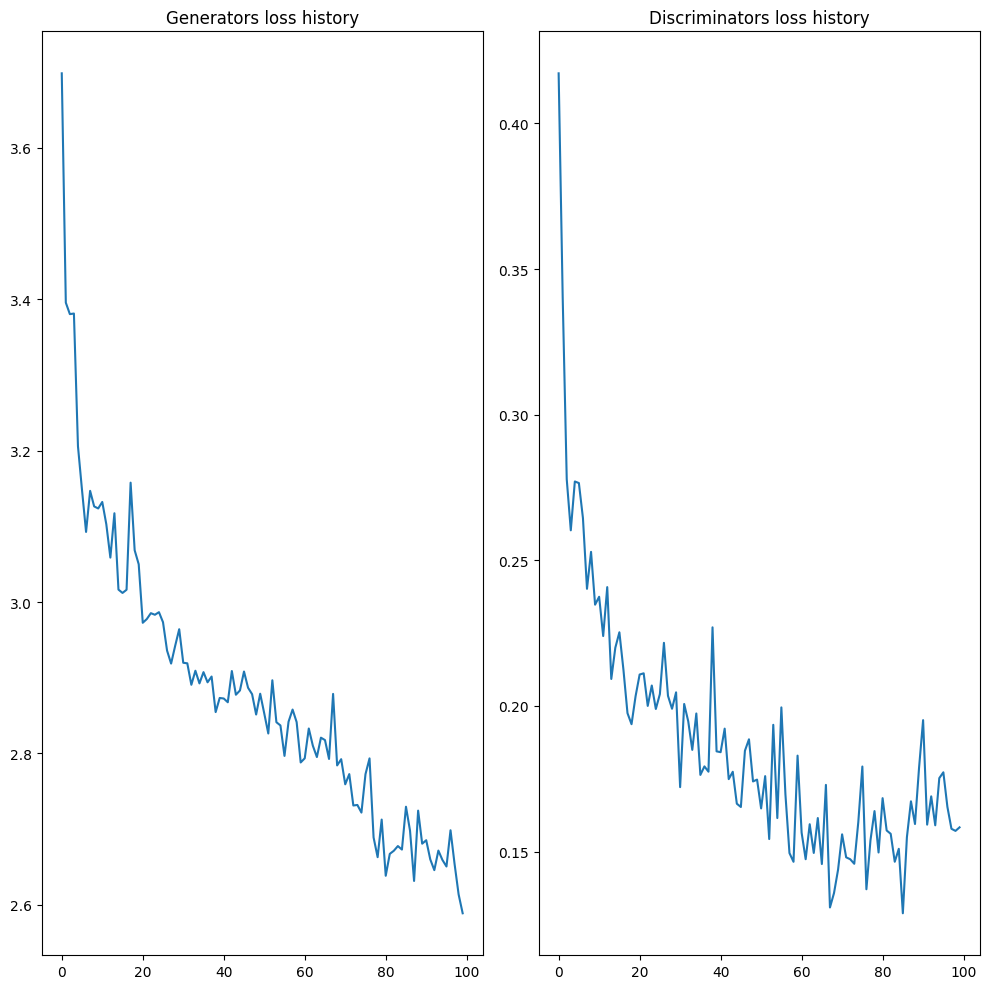

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

ax[0].set_title("Generators loss history")
ax[0].plot(generators_history)

ax[1].set_title("Discriminators loss history")
ax[1].plot(discriminators_history)

plt.tight_layout()
plt.show()

## Visualisation

- **Segmentation map -> Facade**: works good, though the results have visible artifacts.
- **Facade -> Segmentation map**: segmentation map is not sharp at all and works rather like a semantic segmentation.

In [26]:
def visualise_inference(model_file, 
                        dataset, 
                        indexes,
                        generates_facades = True):
    generator_model = Generator(img_channels=3, num_residuals=9).to(device)
    generator_model.load_state_dict(torch.load(model_file))
    
    figure, axes = plt.subplots(nrows=2, ncols=len(indexes), figsize=(10, 4))
    
    for i, idx in enumerate(indexes):
        image, label = dataset[idx]

        condition = label
        if not generates_facades:
            condition = image

        input = torch.tensor(np.expand_dims(condition, 0)).to(device)
        fake = generator_model(input)
        fake = fake.detach().cpu().numpy()

        fake = np.transpose(fake[0], (1,2,0))
        condition = np.transpose(condition.numpy(), (1,2,0))

        axes[0, i].imshow(cv2.cvtColor(condition, cv2.COLOR_BGR2RGB))
        axes[1, i].imshow(cv2.cvtColor(fake, cv2.COLOR_BGR2RGB))

    plt.tight_layout(pad=1)
    plt.show()    

In [14]:
validation_samples = np.random.choice(range(len(facades_val_dataset)), 6)
validation_samples

array([17, 90, 95, 18, 67, 44])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


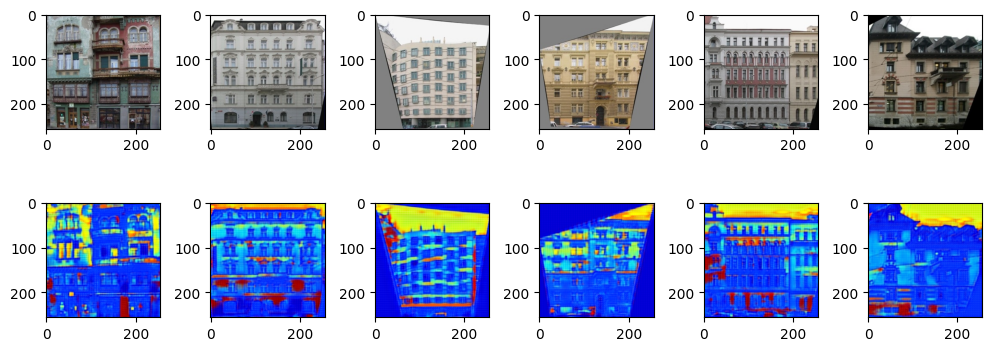

In [27]:
visualise_inference(os.path.join(weights_dir, 'generator-x-099-2.589.pt'), facades_val_dataset, validation_samples, generates_facades = False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


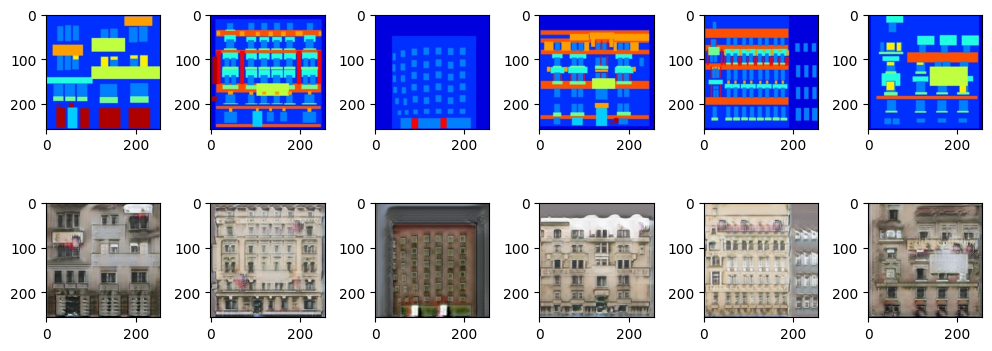

In [28]:
visualise_inference(os.path.join(weights_dir, 'generator-y-099-2.589.pt'), facades_val_dataset, validation_samples, generates_facades = True)

The results seems plausible and quite real, though _Pix2Pix_ produces better results.
At the same time we got 2 generators from _segmented facade_ to _real images_ and vice versa, while _Pix2Pix_ learns mapping in one direction only.